In [1]:
import DataLoader, Training, os
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Run Benchmark
parameters = {
    # data
    "data_path": "F:/Masterthesis/Data",
    "task": "N170",
    "preprocessing": "medium",
    "n_subjects": 40,
    "reject_incorrect_responses": True,
    # model
    "model": "eegnet",
    "n_classes": 2,
    "n_chans": 30,
    "input_window_samples": 1025,
    "seed": 42,
    # classifier
    "lr": 0.001,
    "weight_decay": 0,
    "batch_size": 64,
    "n_epochs": 35,
    "n_splits": 5,
    "model_folder": "models_run3"
}
results = []
for model in ["eegnet", "shallow", "deep"]:
    parameters["model"] = model
    if model == "eegnet":
        parameters["lr"] = 0.001
    elif model == "shallow":
        parameters["lr"] = 0.000625
    elif model == "deep":
        parameters["lr"] = 0.01
        parameters["weight_decay"] = 0.0005
    for preprocessing in ["light", "medium", "heavy"]:
        parameters["preprocessing"] = preprocessing
        for task in ["N170", "N400", "P3"]:
            parameters["task"] = task
            parameters["task"] = task
            df = Dataloader.load_df(parameters)
            data, labels = Dataloader.create_data_labels(df)
            Training.run_exp(data, labels, parameters)

In [9]:
# Get Results
results = []
for model in ["eegnet", "shallow", "deep"]:
    parameters["model"] = model
    for preprocessing in ["light", "medium", "heavy"]:
        parameters["preprocessing"] = preprocessing
        for task in ["N170", "N400", "P3"]:
            parameters["task"] = task
            df = Training.load_exp(parameters)
            df["Model"] = model
            df["Preprocessing"] = preprocessing
            df["Task"] = task
            results.append(df.iloc[-1])
df_results = pd.concat(results, axis=1)
df_results = df_results.transpose().reset_index()
# Put results in correct dataframe for seaborn plot
df_task = df_results[["Task", "Model", "Preprocessing","valid_balanced_accuracy"]]
df_task = df_task.rename(columns={"valid_balanced_accuracy": "Validation Balanced Accuracy"})
list = []
for i in range(3,8):
    list.append(df_task.iloc[:,[0,1,2,i]])
df_task = pd.concat(list, axis=0)

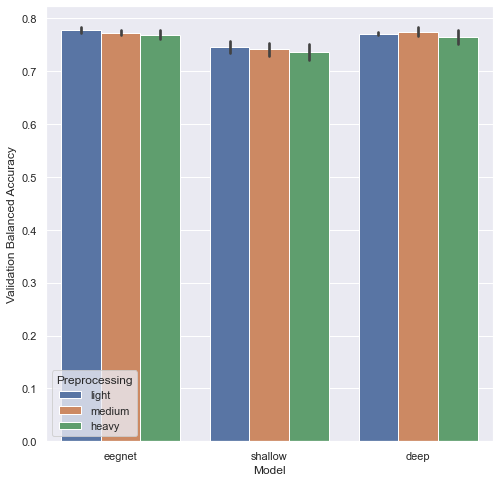

In [10]:
# N170 plot
sns.set(style="darkgrid")
plt.figure(figsize=(8, 8))
sns.barplot(x="Model", y="Validation Balanced Accuracy", 
            hue="Preprocessing", 
            data=df_task[df_task["Task"]=="N170"], ci="sd");

<Figure size 576x576 with 0 Axes>

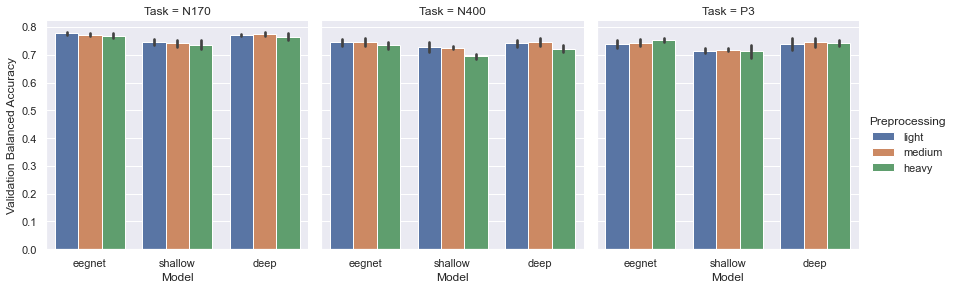

In [11]:
# plot by tasks
sns.set(style="darkgrid")
plt.figure(figsize=(8, 8))
sns.catplot(x="Model", y="Validation Balanced Accuracy",
            hue="Preprocessing", col="Task",
            data=df_task, kind="bar",
            height=4, aspect=1, ci="sd");

<Figure size 576x576 with 0 Axes>

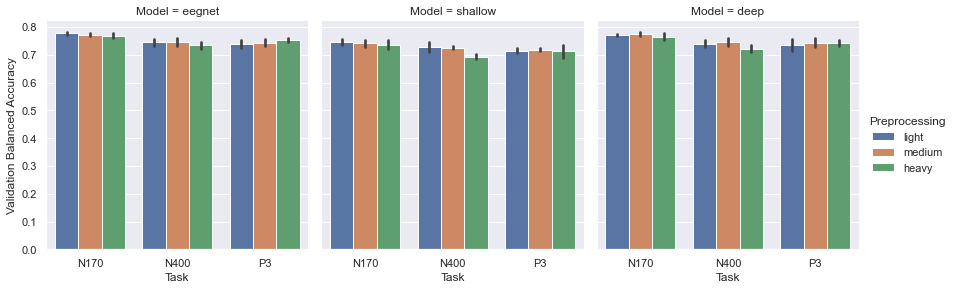

In [12]:
# plot by model
sns.set(style="darkgrid")
plt.figure(figsize=(8, 8))
sns.catplot(x="Task", y="Validation Balanced Accuracy",
            hue="Preprocessing", col="Model",
            data=df_task, kind="bar",
            height=4, aspect=1, ci="sd");

# Per Subject Test

In [ ]:
parameters = {
    # data
    "data_path": "F:/Masterthesis/Data",
    "task": "N170",
    "preprocessing": "medium",
    "n_subjects": 40,
    "reject_incorrect_responses": True,
    # model
    "model": "eegnet",
    "n_classes": 2,
    "n_chans": 30,
    "input_window_samples": 1025,
    "seed": 42,
    # classifier
    "lr": 0.001,
    "weight_decay": 0,
    "batch_size": 64,
    "n_epochs": 35,
    "n_splits": 5,
    "model_folder": "models_single_subject"
}
df = DataLoader.load_df(parameters)
Training.run_exp_per_subject(df, parameters)

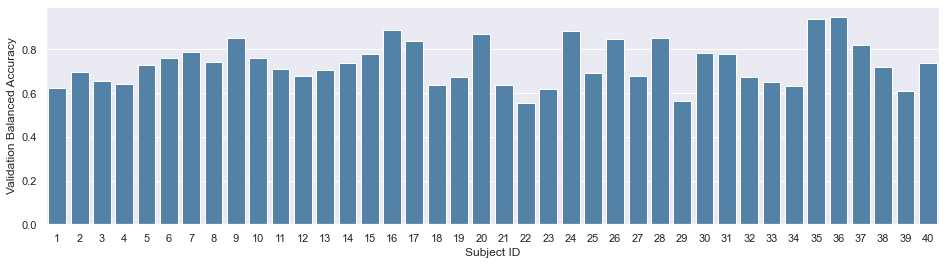

In [57]:
# TODO: Multiple Tasks, maybe also a version with task accuracies normalized
model_path = os.getcwd()+"\\"+parameters["model_folder"]+"\\"+parameters[
        "model"]+"\\"+parameters["task"]+"\\"+parameters["preprocessing"]+"\\"
df_list = []
for i in range(40):
    df_list.append(pd.read_json(model_path+"split_"+str(i)+"_history.json"))
df = pd.concat(df_list,axis=1)
sns.set(style="darkgrid")
plt.figure(figsize=(16, 4))
fig = sns.barplot(x=list(range(1,41)), y=df["valid_balanced_accuracy"].iloc[-1], data=df, palette=['SteelBlue'])
fig.set(xlabel='Subject ID', ylabel='Validation Balanced Accuracy');

# Confusion Matrix

In [15]:
import numpy as np
import sklearn
from sklearn.metrics import confusion_matrix

parameters = {
    # data
    "data_path": "F:/Masterthesis/Data",
    "task": "P3",
    "preprocessing": "medium",
    "n_subjects": 40,
    "reject_incorrect_responses": True,
    # model
    "model": "eegnet",
    "n_classes": 2,
    "n_chans": 30,
    "input_window_samples": 1025,
    "seed": 42,
    # classifier
    "lr": 0.001,
    "weight_decay": 0,
    "batch_size": 64,
    "n_epochs": 35,
    "n_splits": 5,
    "model_folder": "models_run3"
}

## load model to predict on different split
model_path = os.getcwd()+"\\"+str(parameters["model_folder"])+"\\"+str(parameters["model"])+"\\"+str(
        parameters["task"])+"\\"+str(parameters["preprocessing"])+"\\"
df = DataLoader.load_df(parameters)
data, labels = DataLoader.create_data_labels(df)

cv = sklearn.model_selection.StratifiedShuffleSplit(parameters["n_splits"], test_size=0.2, random_state=42)
cv_split = cv.split(data,labels)
# train and validate on each split, then save parameters and history
i = 0
cf_list = []
for train_idx, test_idx in cv_split:
    i += 1
    clf = Training.init_model(parameters)
    clf.load_params(f_params=model_path+"split_"+str(i)+"_model.pkl",
                    f_optimizer=model_path+"split_"+str(i)+"_optimizer.pkl",
                    f_history=model_path+"split_"+str(i)+"_history.json")
    print(clf.score(data[test_idx], labels[test_idx]))

    a = clf.predict(data[test_idx])
    b = labels[test_idx]
    cf_list.append(confusion_matrix(a, b))
    

0.7315614617940199
0.7627906976744186
0.7209302325581395
0.7342192691029901
0.748172757475083


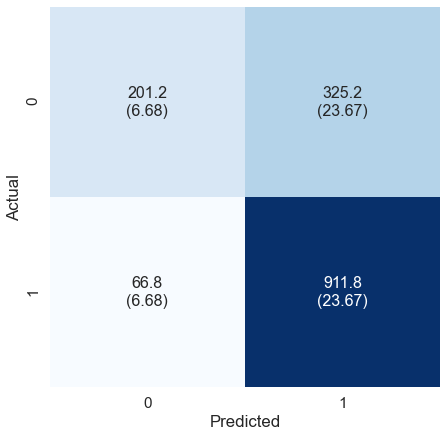

In [96]:
y_true = ["0", "1"]
y_pred = ["0", "1"]
df_cm = pd.DataFrame(np.stack(cf_list).mean(axis=0), columns=np.unique(y_true), index = np.unique(y_true))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
x = np.round(np.stack(cf_list).mean(axis=0),2).astype(str)
y = np.round(np.stack(cf_list).std(axis=0),2).astype(str)
labels = np.char.add(np.char.add(np.char.add(x,"\n("),y),")")
plt.figure(figsize = (7,7))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, cmap="Blues", annot=labels, annot_kws={"size": 16},
            fmt='', cbar=False);

In [107]:
import numpy as np
import sklearn
from sklearn.metrics import confusion_matrix

parameters = {
    # data
    "data_path": "F:/Masterthesis/Data",
    "task": "P3",
    "preprocessing": "medium",
    "n_subjects": 40,
    "reject_incorrect_responses": True,
    # model
    "model": "eegnet",
    "n_classes": 2,
    "n_chans": 30,
    "input_window_samples": 1025,
    "seed": 42,
    # classifier
    "lr": 0.001,
    "weight_decay": 0,
    "batch_size": 64,
    "n_epochs": 35,
    "n_splits": 5,
    "model_folder": "models_run3"
}

df_cm_list = []
for task in ["N170", "N400", "P3"]:
    parameters["task"] = task
    ## load model to predict on different split
    model_path = os.getcwd()+"\\"+str(parameters["model_folder"])+"\\"+str(parameters["model"])+"\\"+str(
                    parameters["task"])+"\\"+str(parameters["preprocessing"])+"\\"
    df = DataLoader.load_df(parameters)
    data, labels = DataLoader.create_data_labels(df)

    cv = sklearn.model_selection.StratifiedShuffleSplit(parameters["n_splits"], test_size=0.2, random_state=42)
    cv_split = cv.split(data,labels)
    # train and validate on each split, then save parameters and history
    i = 0
    cf_list = []
    for train_idx, test_idx in cv_split:
        i += 1
        clf = Training.init_model(parameters)
        clf.load_params(f_params=model_path+"split_"+str(i)+"_model.pkl",
                        f_optimizer=model_path+"split_"+str(i)+"_optimizer.pkl",
                        f_history=model_path+"split_"+str(i)+"_history.json")
        a = clf.predict(data[test_idx])
        b = labels[test_idx]
        cf_list.append(confusion_matrix(a, b))
    df_cm_list.append(pd.DataFrame(np.stack(cf_list).mean(axis=0), columns=np.unique(y_true), index = np.unique(y_true)))
    #df_cm_sd_list.append(pd.DataFrame(np.stack(cf_list).std(axis=0), columns=np.unique(y_true), index = np.unique(y_true)))
df_cm_list

[       0      1
 0  442.4  133.4
 1  129.6  451.6,
        0      1
 0  242.6  111.2
 1   67.4  269.8,
        0      1
 0  201.2  325.2
 1   66.8  911.8]

In [129]:
for i in df_cm_list:
    print (i)

       0      1
0  442.4  133.4
1  129.6  451.6
       0      1
0  242.6  111.2
1   67.4  269.8
       0      1
0  201.2  325.2
1   66.8  911.8


In [ ]:
# TODO: https://github.com/gemeinl/auto-eeg-diagnosis-comparison/blob/master/code/confusion_matrices.ipynb